## Importing Libraries

In [1]:
import sys
import numpy as np
import os
from pathlib import Path


IS_COLAB = "google.colab" in sys.modules

import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

np.random.seed(40)
tf.random.set_seed(40)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



In [2]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Dataset

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [4]:
np.random.seed(40)
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [5]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


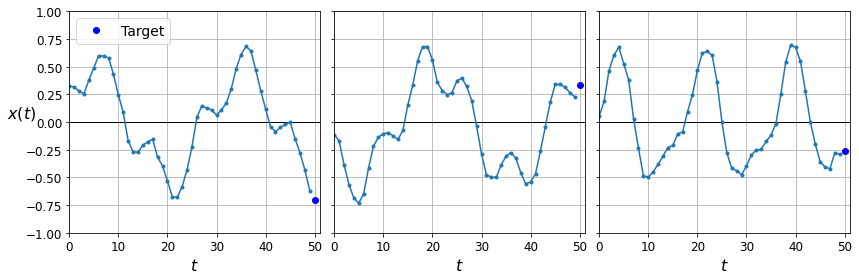

In [8]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
    
save_fig("time_series_plot")
plt.show()

# RNN's

### Baselines

In [9]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.019361245

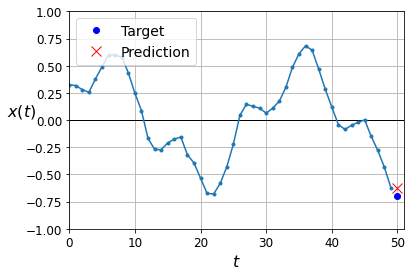

In [10]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Linear predictions

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 4ms/step - loss: 0.1034 - val_loss: 0.0535
Epoch 2/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0392 - val_loss: 0.0270
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0161
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.0062

In [12]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0040


0.004049912095069885

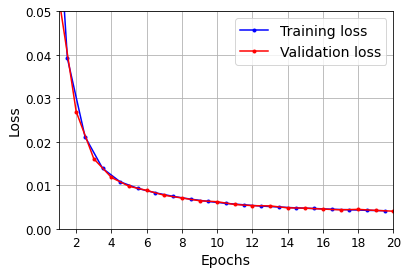

In [13]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

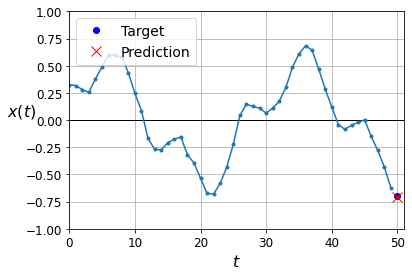

In [14]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 43ms/step - loss: 0.0979 - val_loss: 0.0448
Epoch 2/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0365 - val_loss: 0.0271
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0248 - val_loss: 0.0202
Epoch 4/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0193 - val_loss: 0.0164
Epoch 5/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0162 - val_loss: 0.0141
Epoch 6/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0142 - val_loss: 0.0127
Epoch 7/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0130 - val_loss: 0.0118
Epoch 8/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 9/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 10/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0114 - val_l

In [16]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0108


0.010773913934826851

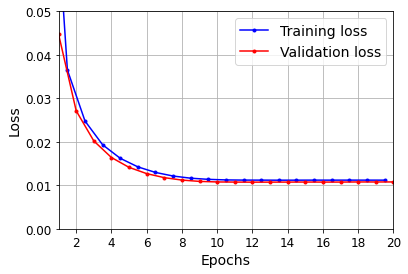

In [17]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

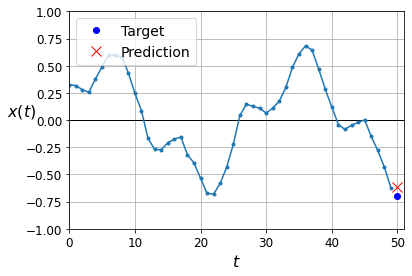

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [19]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 29s 124ms/step - loss: 0.0523 - val_loss: 0.0087
Epoch 2/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 3/20
219/219 [==============================] - 26s 119ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 4/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 5/20
219/219 [==============================] - 25s 116ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 6/20
219/219 [==============================] - 29s 134ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 7/20
219/219 [==============================] - 28s 127ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 8/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 9/20
219/219 [==============================] - 27s 123ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 10/20
219/219 [==============================] - 28s 127ms/step - l

In [20]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0030


0.003023762721568346

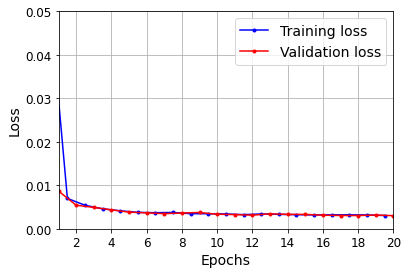

In [21]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

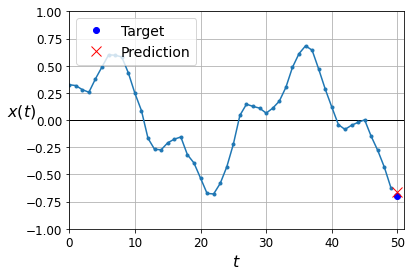

In [22]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## SimpleRNN

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 18s 78ms/step - loss: 0.0224 - val_loss: 0.0049
Epoch 2/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 3/20
219/219 [==============================] - 18s 80ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 5/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/20
219/219 [==============================] - 27s 125ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/20
219/219 [==============================] - 24s 108ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 10/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0

In [24]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0030


0.002964386949315667

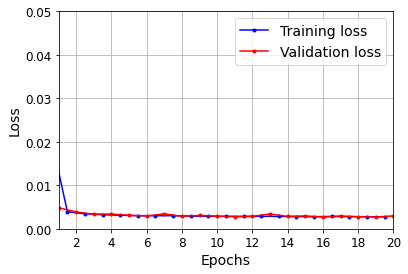

In [25]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

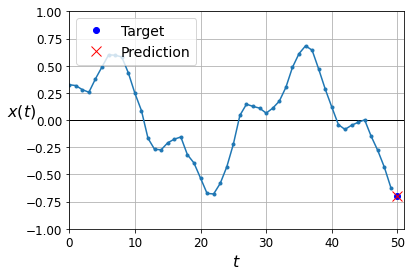

In [26]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [27]:
np.random.seed(45) 

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [28]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


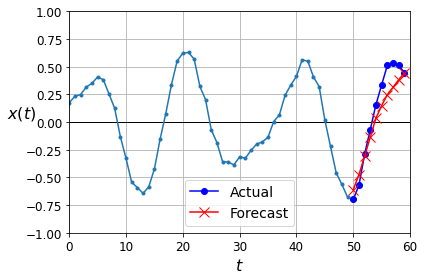

In [29]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Predicting the next 10 values

In [30]:
np.random.seed(50)
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Predicting the next 10 values one by one

In [31]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [32]:
Y_pred.shape

(2000, 10)

In [33]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.026092865

## Comparing this performance with some baselines: naive predictions and a simple linear model

In [34]:
Y_naive_pred = np.tile(X_valid[:, -1], 10)
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.2672857

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1338 - val_loss: 0.0601
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0498 - val_loss: 0.0428
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0386 - val_loss: 0.0359
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0333 - val_loss: 0.0319
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0299 - val_loss: 0.0292
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0275 - val_loss: 0.0272
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0258 - val_loss: 0.0259
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0249
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0236 - val_loss: 0.0240
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0228 - val_loss: 0.0232

### RNN that predicts all 10 next values at once

In [36]:
np.random.seed(48)
tf.random.set_seed(48)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 18s 78ms/step - loss: 0.0559 - val_loss: 0.0333
Epoch 2/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0238 - val_loss: 0.0194
Epoch 3/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0176 - val_loss: 0.0153
Epoch 4/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0146 - val_loss: 0.0136
Epoch 5/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0136 - val_loss: 0.0140
Epoch 6/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0131 - val_loss: 0.0132
Epoch 7/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0128 - val_loss: 0.0118
Epoch 8/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0120 - val_loss: 0.0143
Epoch 9/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 10/20
219/219 [==============================] - 17s 78ms/step - loss: 0.011

In [37]:
np.random.seed(45)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

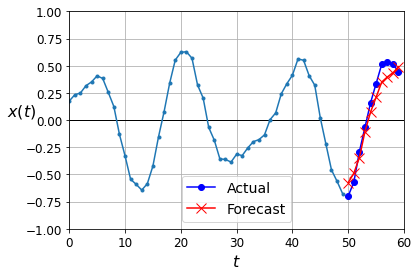

In [38]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Creating an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step.

In [39]:
np.random.seed(47)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [40]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [41]:
np.random.seed(41)
tf.random.set_seed(41)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 19s 80ms/step - loss: 0.0517 - last_time_step_mse: 0.0407 - val_loss: 0.0431 - val_last_time_step_mse: 0.0317
Epoch 2/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0380 - last_time_step_mse: 0.0258 - val_loss: 0.0346 - val_last_time_step_mse: 0.0228
Epoch 3/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0321 - last_time_step_mse: 0.0197 - val_loss: 0.0295 - val_last_time_step_mse: 0.0161
Epoch 4/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0285 - last_time_step_mse: 0.0161 - val_loss: 0.0275 - val_last_time_step_mse: 0.0150
Epoch 5/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0258 - last_time_step_mse: 0.0134 - val_loss: 0.0234 - val_last_time_step_mse: 0.0098
Epoch 6/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0233 - last_time_step_mse: 0.0107 - val_loss: 0.0220 - val_last_time_step_mse: 0.0090
Epoch 7/20
219/2

In [42]:
np.random.seed(44)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

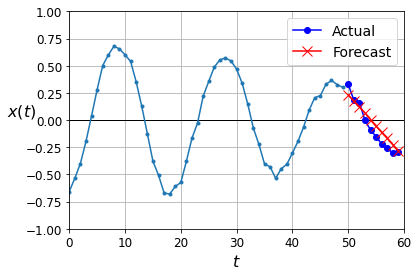

In [43]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN

## Deep RNN with Batch Norm

In [44]:
np.random.seed(50)
tf.random.set_seed(50)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 19s 79ms/step - loss: 0.1891 - last_time_step_mse: 0.1967 - val_loss: 0.0847 - val_last_time_step_mse: 0.0811
Epoch 2/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0523 - last_time_step_mse: 0.0425 - val_loss: 0.0491 - val_last_time_step_mse: 0.0381
Epoch 3/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0435 - last_time_step_mse: 0.0322 - val_loss: 0.0422 - val_last_time_step_mse: 0.0311
Epoch 4/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0400 - last_time_step_mse: 0.0286 - val_loss: 0.0391 - val_last_time_step_mse: 0.0282
Epoch 5/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0376 - last_time_step_mse: 0.0259 - val_loss: 0.0379 - val_last_time_step_mse: 0.0263
Epoch 6/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0352 - last_time_step_mse: 0.0232 - val_loss: 0.0345 - val_last_time_step_mse: 0.0227
Epoch 7/20
219/2

## Deep RNNs with Layer Norm

In [45]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 41s 168ms/step - loss: 0.1588 - last_time_step_mse: 0.1567 - val_loss: 0.0706 - val_last_time_step_mse: 0.0648
Epoch 2/20
219/219 [==============================] - 38s 171ms/step - loss: 0.0617 - last_time_step_mse: 0.0547 - val_loss: 0.0561 - val_last_time_step_mse: 0.0494
Epoch 3/20
219/219 [==============================] - 37s 170ms/step - loss: 0.0525 - last_time_step_mse: 0.0447 - val_loss: 0.0483 - val_last_time_step_mse: 0.0402
Epoch 4/20
219/219 [==============================] - 37s 167ms/step - loss: 0.0453 - last_time_step_mse: 0.0357 - val_loss: 0.0422 - val_last_time_step_mse: 0.0320
Epoch 5/20
219/219 [==============================] - 37s 168ms/step - loss: 0.0403 - last_time_step_mse: 0.0295 - val_loss: 0.0386 - val_last_time_step_mse: 0.0271
Epoch 6/20
219/219 [==============================] - 37s 170ms/step - loss: 0.0372 - last_time_step_mse: 0.0258 - val_loss: 0.0363 - val_last_time_step_mse: 0.0238
Epoch 7/20

# Custom RNN Class

In [47]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [48]:
np.random.seed(46)
tf.random.set_seed(46)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 41s 180ms/step - loss: 0.1376 - last_time_step_mse: 0.1288 - val_loss: 0.0630 - val_last_time_step_mse: 0.0533
Epoch 2/20
219/219 [==============================] - 39s 177ms/step - loss: 0.0588 - last_time_step_mse: 0.0485 - val_loss: 0.0551 - val_last_time_step_mse: 0.0457
Epoch 3/20
219/219 [==============================] - 39s 177ms/step - loss: 0.0527 - last_time_step_mse: 0.0421 - val_loss: 0.0503 - val_last_time_step_mse: 0.0407
Epoch 4/20
219/219 [==============================] - 39s 176ms/step - loss: 0.0476 - last_time_step_mse: 0.0362 - val_loss: 0.0451 - val_last_time_step_mse: 0.0333
Epoch 5/20
219/219 [==============================] - 39s 177ms/step - loss: 0.0426 - last_time_step_mse: 0.0298 - val_loss: 0.0408 - val_last_time_step_mse: 0.0275
Epoch 6/20
219/219 [==============================] - 39s 178ms/step - loss: 0.0385 - last_time_step_mse: 0.0248 - val_loss: 0.0371 - val_last_time_step_mse: 0.0227
Epoch 7/20

# LSTMs

In [49]:
np.random.seed(52)
tf.random.set_seed(52)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 11ms/step - loss: 0.0805 - last_time_step_mse: 0.0671 - val_loss: 0.0549 - val_last_time_step_mse: 0.0386
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0470 - last_time_step_mse: 0.0256 - val_loss: 0.0413 - val_last_time_step_mse: 0.0181
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0386 - last_time_step_mse: 0.0175 - val_loss: 0.0371 - val_last_time_step_mse: 0.0170
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0350 - last_time_step_mse: 0.0149 - val_loss: 0.0340 - val_last_time_step_mse: 0.0146
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0327 - last_time_step_mse: 0.0135 - val_loss: 0.0320 - val_last_time_step_mse: 0.0130
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0313 - last_time_step_mse: 0.0130 - val_loss: 0.0307 - val_last_time_step_mse: 0.0121
Epoch 7/20
219/219 [=======

In [50]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0236 - last_time_step_mse: 0.0081


[0.023624500259757042, 0.008108162321150303]

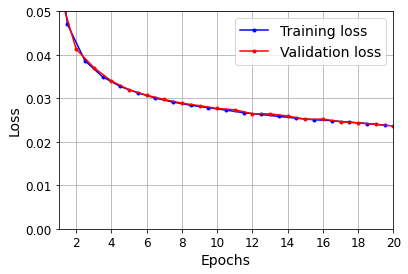

In [51]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [52]:
np.random.seed(53)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

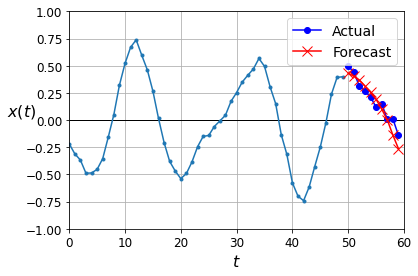

In [53]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 11ms/step - loss: 0.0740 - last_time_step_mse: 0.0660 - val_loss: 0.0516 - val_last_time_step_mse: 0.0412
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0474 - last_time_step_mse: 0.0372 - val_loss: 0.0442 - val_last_time_step_mse: 0.0335
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0419 - last_time_step_mse: 0.0308 - val_loss: 0.0401 - val_last_time_step_mse: 0.0285
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0377 - last_time_step_mse: 0.0257 - val_loss: 0.0354 - val_last_time_step_mse: 0.0228
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0333 - last_time_step_mse: 0.0193 - val_loss: 0.0326 - val_last_time_step_mse: 0.0188
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0308 - last_time_step_mse: 0.0157 - val_loss: 0.0302 - val_last_time_step_mse: 0.0148
Epoch 7/20
219/219 [=======

In [55]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0246 - last_time_step_mse: 0.0115


[0.024644896388053894, 0.011474940925836563]

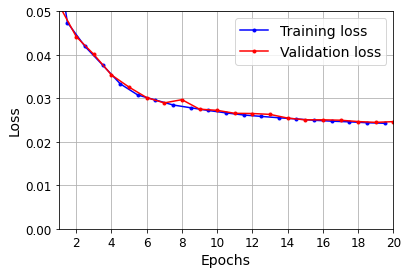

In [56]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [57]:
np.random.seed(40)
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

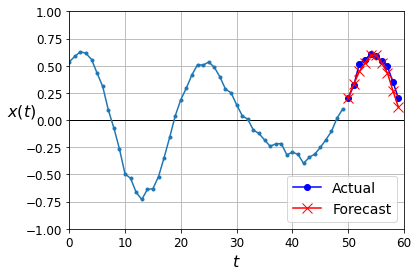

In [58]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59
```

In [59]:
np.random.seed(57)
tf.random.set_seed(55)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 13s 10ms/step - loss: 0.0670 - last_time_step_mse: 0.0607 - val_loss: 0.0432 - val_last_time_step_mse: 0.0367
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0377 - last_time_step_mse: 0.0310 - val_loss: 0.0358 - val_last_time_step_mse: 0.0284
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0329 - last_time_step_mse: 0.0254 - val_loss: 0.0310 - val_last_time_step_mse: 0.0221
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0295 - last_time_step_mse: 0.0209 - val_loss: 0.0279 - val_last_time_step_mse: 0.0180
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0266 - last_time_step_mse: 0.0168 - val_loss: 0.0257 - val_last_time_step_mse: 0.0152
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0248 - last_time_step_mse: 0.0148 - val_loss: 0.0245 - val_last_time_step_mse: 0.0146
Epoch 7/20
219/219 [======

In [60]:
np.random.seed(60)
tf.random.set_seed(60)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 6s 10ms/step - loss: 0.0708 - last_time_step_mse: 0.0633 - val_loss: 0.0489 - val_last_time_step_mse: 0.0424
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0391 - last_time_step_mse: 0.0318 - val_loss: 0.0337 - val_last_time_step_mse: 0.0259
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0302 - last_time_step_mse: 0.0213 - val_loss: 0.0278 - val_last_time_step_mse: 0.0170
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0263 - last_time_step_mse: 0.0162 - val_loss: 0.0252 - val_last_time_step_mse: 0.0140
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0244 - last_time_step_mse: 0.0139 - val_loss: 0.0237 - val_last_time_step_mse: 0.0126
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0231 - last_time_step_mse: 0.0122 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [======

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [61]:
np.random.seed(50)
tf.random.set_seed(50)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0657 - last_time_step_mse: 0.0524 - val_loss: 0.0362 - val_last_time_step_mse: 0.0218
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0321 - last_time_step_mse: 0.0193 - val_loss: 0.0298 - val_last_time_step_mse: 0.0169
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0283 - last_time_step_mse: 0.0158 - val_loss: 0.0274 - val_last_time_step_mse: 0.0149
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0267 - last_time_step_mse: 0.0143 - val_loss: 0.0263 - val_last_time_step_mse: 0.0141
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0255 - last_time_step_mse: 0.0130 - val_loss: 0.0248 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0246 - last_time_step_mse: 0.0122 - val_loss: 0.0249 - val_last_time_step_mse: 0.0127
Epoch 7/20
219/219 [========

it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences

In [62]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [63]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [64]:
keras.backend.clear_session()
np.random.seed(52)
tf.random.set_seed(52)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [66]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 11ms/step - loss: 0.1213 - last_time_step_mse: 0.1157 - val_loss: 0.1212 - val_last_time_step_mse: 0.1167
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1210 - last_time_step_mse: 0.1153 - val_loss: 0.1209 - val_last_time_step_mse: 0.1163
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1208 - last_time_step_mse: 0.1151 - val_loss: 0.1207 - val_last_time_step_mse: 0.1162
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1207 - last_time_step_mse: 0.1150 - val_loss: 0.1206 - val_last_time_step_mse: 0.1161
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1205 - last_time_step_mse: 0.1148 - val_loss: 0.1205 - val_last_time_step_mse: 0.1159
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.1204 - last_time_step_mse: 0.1148 - val_loss: 0.1204 - val_last_time_step_mse: 0.1159
Epoch 7/20
219/219 [=======

In [67]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.1197 - last_time_step_mse: 0.1153


[0.11969683319330215, 0.11528103798627853]